```accel-realapps-ann-runtime-single.ipynb```
#    <font color='red'>Study Title: Performance-Aware Energy-Efficient GPU Frequency Selection using DNN-based Models</font>

> ***venue:*** Accepted at 52nd International Conference on Parallel Processing (ICPP) 2023

> ***Authors:*** Ghazanfar ALI *and* Mert SIDE

<hr style="border:2px solid gray">


***README***

First three code cells are used to include the needed libraries, sets global variables, and define shared functions. Please run them before running anything else


___
### IMPORT LIBRARIES AND SET GLOBAL VARIABLES

In [10]:
#!/usr/bin/python3

# IMPORT LIBRARIES AND SET GLOBAL VARIABLES ----------------------------------

# GENERIC
import sys
import statistics
import itertools
import datetime as dt
from os import error
from typing_extensions import runtime

# NUMPY
import numpy as np
from numpy.lib import type_check
from numpy.core.fromnumeric import mean

# PANDAS
import pandas as pd

# MATPLOTLIB
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as plticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import Normalize
from matplotlib.offsetbox import (TextArea, 
                                  DrawingArea, 
                                  OffsetImage, 
                                  AnnotationBbox)
from matplotlib.patches import Rectangle

# SEABORN
import seaborn as sns
from seaborn.palettes import color_palette

# SKLEARN
import sklearn
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.utils import shuffle

# MISC.
# from xgboost import XGBRegressor

xss = 6
ss  = 7   # 8
ms  = 8   # 10
ls  = 10   # 12
xls = 14
xxls = 16

matplotlib.rc('xtick', labelsize=ls) 
matplotlib.rc('ytick', labelsize=ls) 

figureExtension = '.pdf'
# figureExtension = '.png'
# figureExtension = '.svg'
preferredDPI = 400
# ============================================================================

___
### Set global color, hatch and marker standards

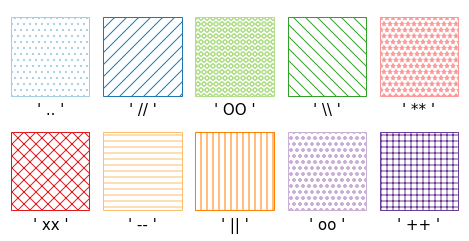

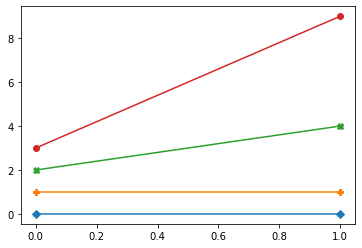

In [11]:
# DEMO hatches ===============================================================
fig, axs = plt.subplots(2, 5, constrained_layout=True, figsize=(6.4, 3.2),
                        facecolor='white')

# SWATCHES -------------------------------------------------------------------
baseColors  = sns.color_palette("Paired")
baseHatches = ['..', '//', 'OO', '\\\\', '**', 'xx', '--', '||', 'oo', '++'] # ['oo', 'xx', '++', '//', '\\\\', '--', '||', '..', '**', 'OO']
baseMarkers = ['D', 'P', 'X', 'o'] # ['o', 'X', 'P', 'D']
alternateColors = ['r', 'g', 'b', 'm', 'y', 'c']
#  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---

markerSize = 50

baseLineColor = 'deeppink'
baseLinewidth = 2
baseArrowColor = 'tomato'
#  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
# https://matplotlib.org/stable/api/markers_api.html

# colors = itertools.cycle(['r','g', 'b', 'm', 'y', 'c'])
# MARKERS ['o', '+', '*', '.', 'x', '_', '|', 's', 'd', '^', 'v', 
#          '>', '<', 'p', 'h', 'X', '8', '1', '2',',','P']

colors=itertools.cycle(baseColors)
hatches=itertools.cycle(baseHatches)
markers=itertools.cycle(baseMarkers)

def hatches_plot(ax, h):
    ax.add_patch(Rectangle((0, 0), 2, 2, fill=False, hatch=h, color=next(colors)))
    ax.text(1, -0.5, f"' {h} '", size=15, ha='center')
    ax.axis('equal')
    ax.axis('off')

for ax, h in zip(axs.flat, hatches):
    hatches_plot(ax, h)
   
plt.show()

plt.close()

i = 0
for m in baseMarkers:
    plt.plot([i, i*i], marker=next(markers))
    i = i + 1
# END OF DEMO hatches ========================================================

___
### Global Functions

___
___
___


c:\Users\Ghazanfar\anaconda3\envs\gpu-dl\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


selu <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x00000234354EA288>
1 2
Execution time: 5.331365


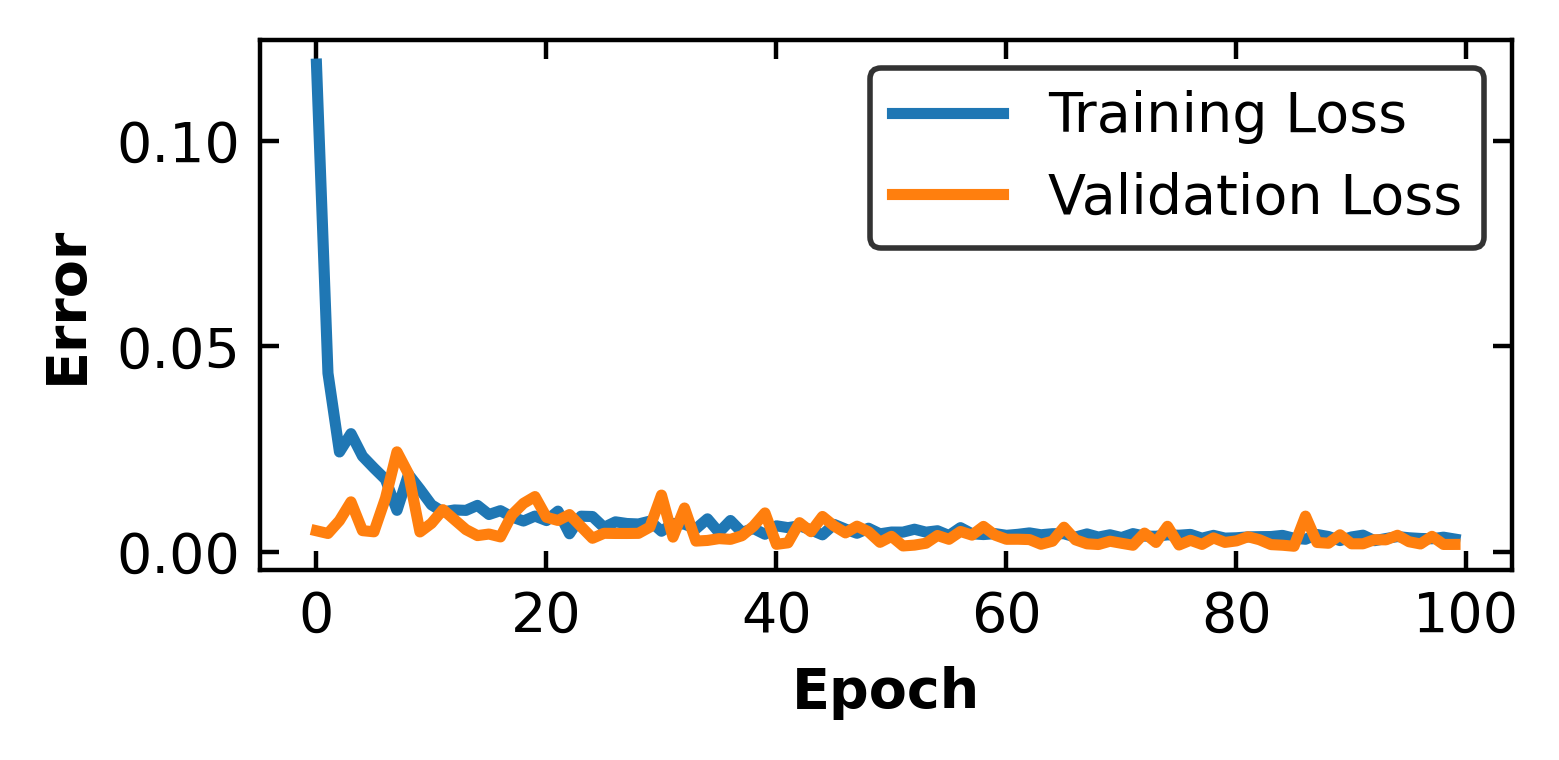

In [12]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import tensorflow as tf

from keras.layers import Dropout
from keras import regularizers
from sklearn.metrics import mean_absolute_percentage_error

# SWATCHES -------------------------------------------------------------------
colors  = itertools.cycle(baseColors[0:2])
hatches = itertools.cycle(baseHatches)
markers = itertools.cycle(baseMarkers)
marker_size = markerSize
#  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---

'''
# opt = tf.keras.optimizers.SGD(learning_rate=0.01)
# opt = tf.keras.optimizers.Adam(learning_rate=0.002) # with elu (time)
# opt = tf.keras.optimizers.Adadelta(learning_rate=0.01)
# opt = tf.keras.optimizers.Adagrad(learning_rate=0.01)
# opt = tf.keras.optimizers.Adamax(learning_rate=0.01) #  with tanh (power)
# opt = tf.keras.optimizers.Nadam(learning_rate=0.01)
# opt = tf.keras.optimizers.Ftrl(learning_rate=0.01)
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.01) # with relu (time)
'''

SPEC_dataPath = "../datasets/SPEC_A100/"
dgemm_Stream_DataPath = "../datasets/dgemm_stream/"
HPC_DataPath = "../datasets/hpc/"

models = ['power_usage','n_run_time']
# act_funcs = ['sigmoid','relu','softmax','softplus','softsign','selu', 'tanh', 'elu']
act_funcs = ['selu']

# opts = [tf.keras.optimizers.Adam(),tf.keras.optimizers.Adamax(),tf.keras.optimizers.Nadam(),tf.keras.optimizers.RMSprop()]
opts = [tf.keras.optimizers.RMSprop()]
# model_name = 'n_run_time'

model_name = 'power_usage'
# bm = 'microbm'
df_list = []
app_acc_list = {'NAMD':[],'LAMMPS':[],'GROMACS':[],'LSTM':[]}
f = SPEC_dataPath + 'GA100-dvfs-accel-dcgm.csv'
df = pd.read_csv(f)
# df['fp_active'] = df['fp32_active']
df['fp_active'] = df['fp64_active'].add(df['fp32_active'].div(2))
df['sm_app_clock'] = df['sm_app_clock'].div(max(df['sm_app_clock']))

df_l = []
hpc_apps = ["nw", "kmeans", "ge","tpacf","histo", "cutcp", "srad", "bfs", "spmv", "mriq","stencil","lbm", "bplustree", "fft", "cfd", "lud", "heartwall","lavamd", "hotspot"]
for hpc_app in hpc_apps:
    hpc_app_df = df.loc[df['application'] == hpc_app]
    hpc_app_df['n_power_usage'] = hpc_app_df[model_name].div(max(hpc_app_df[model_name]))
    df_l.append(hpc_app_df)
del df
df = pd.concat(df_l)

apps = ['dgemm','stream']
for app in apps:
    f = dgemm_Stream_DataPath + 'GA100-dvfs-'+app+'-dcgm.csv'
    dat = pd.read_csv(f)    
    if model_name == 'n_run_time':
        dat[model_name] = dat['run_time'].div(max(dat['run_time']))
    elif model_name == 'power_usage':
        dat['n_power_usage'] = dat['power_usage'].div(max(dat['power_usage']))
        dat['sm_app_clock'] = dat['sm_app_clock'].div(max(dat['sm_app_clock']))

    if app == 'dgemm':
        dat['fp_active'] = dat['tensor_activity']
    elif app == 'stream':
        dat['fp_active'] = dat['fp64_active']
    df_list.append(dat)
df_list.append(df)
data1 = pd.concat(df_list)
    
df1 = data1[['fp_active','dram_active','sm_app_clock','n_power_usage']]
df1 = df1.copy()
dataset1 = df1.values
X_train = dataset1[:, :-1]
y_train = dataset1[:, -1]

# Feature Scaling
from sklearn.preprocessing import StandardScaler
import datetime
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)

# for model in models:
for act_func in act_funcs:
    for opt in opts:
        print (act_func, opt)
        for s in range (1,2):
            from numpy.random import seed
            seed(s)
            tf.random.set_seed(s+1)
            print (s,s+1)
            # '''
            # Initialising the ANN
            model = Sequential()

            neurans = 64

            model.add(Dense(units = neurans, activation = act_func, input_dim = 3))

            model.add(Dense(units = neurans, activation = act_func,kernel_initializer='lecun_normal'))

            model.add(Dense(units = neurans, activation = act_func,kernel_initializer='lecun_normal'))

            # Adding the fourth hidden layer
            model.add(Dense(units = neurans, activation = act_func,kernel_initializer='lecun_normal'))

            # Adding the output layer
            model.add(Dense(units = 1))
            # ''' 

            model.compile(optimizer=opt,
                          loss='mean_squared_error',
                          metrics=['mean_absolute_percentage_error'])
            start_time = datetime.datetime.now()
            hist = model.fit(X_train, y_train,
                      batch_size=64, epochs=100,verbose=0,validation_split = 0.2) # 
            end_time = datetime.datetime.now()
            time_diff = (end_time - start_time)
            execution_time = time_diff.total_seconds()
            print ('Execution time:',execution_time)  
            figure(figsize=(4, 2), dpi=400)
            plt.plot(hist.history['loss'], label='Training Loss', linewidth=baseLinewidth)
            plt.plot(hist.history['val_loss'], label='Validation Loss', linewidth=baseLinewidth)
            plt.xlabel('Epoch', fontweight='bold', fontsize=ls)
            plt.ylabel('Error', fontweight='bold', fontsize=ls)
            leg = plt.legend()
            leg.get_frame().set_edgecolor('black')
            plt.tick_params(axis='both', which='major', labelsize=ls, direction = "in", reset=True, color = 'black')
#                 plt.grid(True, linestyle='--')
            plt.grid(False)
            plt.tight_layout()
            plt.savefig('../figures/model_loss/pwr_training_validation_loss_v3' + figureExtension, transparent=True, bbox_inches = 'tight', pad_inches = 0.1, dpi=400)
            plt.show()
            plt.close()